In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
import os

import pathlib

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import scipy.ndimage.morphology as morph  
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import  moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
sys.path.append('..')
import about
import pathcustomize

from waldo.conf import settings
from waldo.wio.experiment import Experiment
from waldo.behavior import Behavior_Coding, Worm_Shape

about.about()

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



Python 2.7.9 (default, Apr 27 2015 14:38:19) [GCC 4.8.2] on linux2, Host: cody


In [3]:
# for some elipses.
Elipse = mpl.patches.Ellipse

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=-1, codec='libx264')

In [8]:
#settings.PROJECT_DATA_ROOT = '../../Data/test'
settings.PROJECT_DATA_ROOT = '../../Data/test'
#'../../data/test/20130318_131056/blob_files/'
pl = pathlib.Path(settings.PROJECT_DATA_ROOT)
pl.absolute()
for i in pl.glob('*'):
    print(i)

In [5]:
day_1_eids = [  '20130318_131056',
                '20130318_131111',
                '20130318_131113',
                '20130318_142605',
                '20130318_142613',
                '20130318_153741',
                '20130318_153742',
                '20130318_153749',
                '20130318_165642',
                '20130318_165643',
                '20130318_165649']

In [6]:
eid = day_1_eids[0]
print(eid)

path = pl / eid / 'blob_files'

e = Experiment(fullpath=path,experiment_id=eid)
typical_bodylength = e.typical_bodylength
b_list = []
for i, (bid, blob) in enumerate(e.blobs()):
    blob_df = blob.df
    if len(blob_df) > 5000:
        t = blob_df['time']
        if t.iloc[-1] - t.iloc[0] > 40 * 60:
            b_list.append(blob_df)

20130318_131056


MWTSummaryError: Could not find summary file in target path: ../../Data/test/20130318_131056/blob_files

In [ ]:
#ls '../../data/test/20130318_131056/blob_files/'

In [ ]:
blob_df = b_list[2]
fig, ax = plt.subplots()
x, y = zip(*blob_df.loc[:,'centroid'])
ax.plot(x, y)
for c in blob_df:
    print(c)

In [ ]:
bc = Behavior_Coding(bl=typical_bodylength)
bc.read_from_blob_df(blob_df=blob_df)
bc.preprocess(dt=0.2)
bc.reassign_front_back(speed_cuttoff = 1.0, ar_cut= 0.8, min_points=5)
bc.df.head() #describe().T

In [10]:
def preprocess_midline(mid_df, dt=0.2):
    mid_df_list = bc.split_df(mid_df, max_gap_seconds=1)
    df_list = []
    window_size = 5
    for mdf in mid_df_list:
        if len(mdf) > window_size:
            mdf = bc.smooth_df(df=mdf, window=window_size)
            mdf = bc.equally_space_df(df=mdf, dt=dt)
            df_list.append(mdf)
    mdf = bc.combine_split_dfs(df_list, min_window_seconds=5)
    return mdf

d = blob_df.dropna(subset=['midline'])

n_rows = len(d)
#x_midlines = np.zeros(shape=(n_rows, 11))
#y_midlines = np.zeros(shape=(n_rows, 11))
x_rows = []
y_rows = []

for i, (_, row) in enumerate(d.iterrows()):
    xi, yi = zip(*row['midline'])
    rx = {i:j for i, j in enumerate(xi)}
    ry = {i:j for i, j in enumerate(yi)}
    rx['frame'] = ry['frame'] =row['frame']
    rx['time'] = ry['time'] = row['time']
    x_rows.append(rx)
    y_rows.append(ry)

x_df = pd.DataFrame(x_rows)
x_df = preprocess_midline(x_df)
y_df = pd.DataFrame(y_rows)
y_df = preprocess_midline(y_df)
x_df.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]



,time,0,1,2,3,4,5,6,7,8,9,10,frame
0,374.8,-4.8,-4.2,-1.6,1.2,2.0,1.2,-1.2,-2.0,-0.2,2.8,4.0,5632
1,375.0,-4.4,-4.2,-2.8,0.6,2.4,1.5,-0.3,-1.9,-0.7,2.4,3.7,5635
2,375.2,-3.0,-4.0,-3.9,-0.7,2.5,1.6,1.1,-1.3,-1.0,1.0,3.6,5638
3,375.4,-1.5,-3.5,-4.0,-1.3,2.2,2.2,2.0,-0.4,-1.0,0.6,3.1,5641
4,375.6,-0.6,-2.8,-3.9,-2.1,1.2,2.7,2.3,0.4,-1.0,0.1,2.5,5643


   frame    time  dx0  dx10  dy0  dy10        d0       d10 forward
0  42916  2851.8  0.4   0.0 -0.2  -0.1  0.447214  0.100000    True
1  42919  2852.0  0.4   0.0 -0.2  -0.1  0.447214  0.100000    True
2  42922  2852.2  0.6   0.2 -0.4  -0.3  0.721110  0.360555    True
3  42925  2852.4  1.4  -0.4 -1.2   0.4  1.843909  0.565685    True
4  42928  2852.6 -0.2   0.1  0.5   0.0  0.538516  0.100000    True


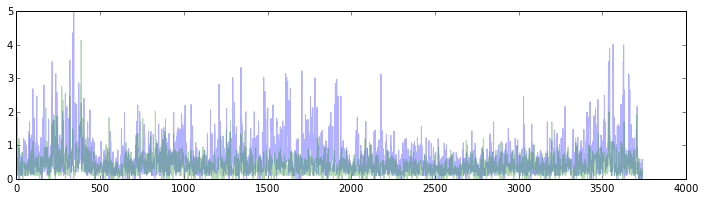

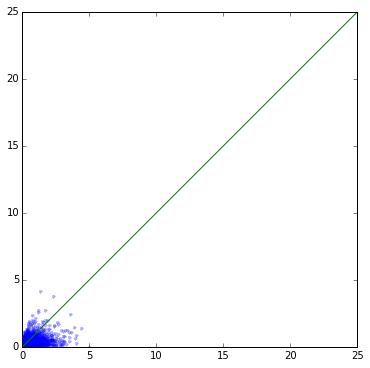

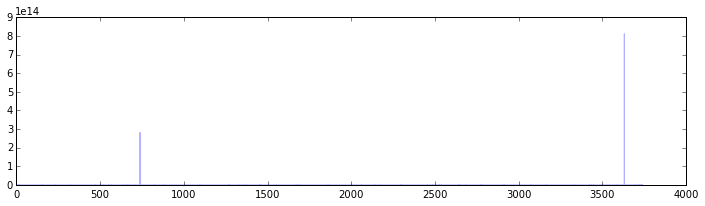

In [11]:
def things(x_df, y_df):
    props = x_df[['frame', 'time']].copy()
    props.loc[:, 'dx0'] = x_df[0].diff()
    props.loc[:, 'dx10'] = x_df[10].diff()
    props.loc[:, 'dy0'] = y_df[0].diff()
    props.loc[:, 'dy10'] = y_df[10].diff()
    props = props.fillna(method='bfill')
    props.loc[:, 'd0'] = np.sqrt(props['dx0']**2 + props['dy0']**2)
    props.loc[:, 'd10'] = np.sqrt(props['dx10']**2 + props['dy10']**2)
    props.loc[:, 'forward'] = props['d0'] > props['d10']
    fig, ax = plt.subplots(figsize=(12,3))
    ax.plot(props['d0'], alpha=0.3)
    ax.plot(props['d10'], alpha=0.3)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(props['d0'], props['d10'], '.', alpha=0.3)
    ax.plot([0, 25], [0, 25])
    
    fig, ax = plt.subplots(figsize=(12,3))
    ax.plot(props['d10'] /props['d0'] , alpha=0.3)
    #ax.plot(props['d10'], alpha=0.3)
    print(props.head())
    
i = 4
df = bc.split_df(bc.df)[i]
x_df2 = bc.split_df(x_df)[i]
y_df2 = bc.split_df(y_df)[i]
things(x_df2, y_df2)

In [12]:
worm_shape = Worm_Shape()
worm_shape.read_blob_df(blob_df)
worm_shape.create_contours()
print(worm_shape.df.head())

61 61
   frame     time  centroid_x  centroid_y  contour_x  contour_y  elipse_angle  \
0   5632  374.778         994          26        988         42      1.598711   
1   5633  374.850         994          26        988         41      1.605166   
2   5634  374.905         994          27        988         41      1.607875   
3   5635  374.983         994          27        988         41      1.610451   
4   5636  375.047         994          28        988         41      1.610565   

   elipse_major  elipse_minor  center_shift_x  center_shift_y  x_max  x_min  \
0          40.3          11.7               6             -16      6     -6   
1          39.3          10.5               6             -15      5     -6   
2          38.3          10.5               6             -14      5     -6   
3          38.4          11.6               6             -14      6     -6   
4          47.3          10.4               6             -13      5     -6   

   y_max  y_min  
0     22    -2

0
0 min index
0


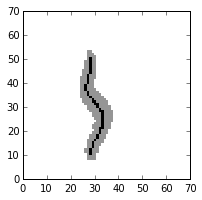

354.0

In [26]:
dfs = bc.split_df(bc.df)
i = 0
print(i)
df = bc.split_df(bc.df)[i]
#df = bc.split_df(bc.df)[i]
desired_frames = np.array(df['frame'])
contours2 = worm_shape.match_contour_frames(desired_frames)

j = 27
im = contours2[j]
im = im + worm_shape.loop_thinning(contours2)[j]
fig, ax = plt.subplots(figsize=(3,3))
ax.pcolormesh(im, cmap=mpl.cm.Greys)
plt.show()

np.sum(im)

366.0

In [15]:
box_min, box_max = 0, len(contours2[0])
box_max

61

In [ ]:
def make_video(df, contours2, x_df2, y_df2, vid_name='shape.mp4'):
    
    print(len(df)-1, 'len')
    ###### initialize figure
    fig_mpl = plt.figure(figsize=(10, 6))

    # prepare initial data
    row = df.iloc[0]
    width = row['length']
    height = row['width']
    angle = row['angle'] * 180. / np.pi
    orr = row['orientation']

    # window_size = 5
    buffer = (len(contours2[0]) - 1) / 2.0
    # x_mid2 = x_mid + buffer
    # y_mid2 = y_mid + buffer
    # x_mid_df = bc.smooth_df(pd.DataFrame(x_mid2), window=window_size, fill_gaps=False)
    # y_mid_df = bc.smooth_df(pd.DataFrame(y_mid2), window=window_size,fill_gaps=False)
    # x_mid2a = np.array(x_mid_df)

    x_mid2 = np.array(x_df2[[i for i in range(11)]]) + buffer
    y_mid2 = np.array(y_df2[[i for i in range(11)]]) + buffer


    ############ SHAPE ############

    ax = plt.subplot()

    box_min, box_max = 0, len(contours2[0])

    # add worm image
    worm_im = ax.imshow(contours2[0], interpolation='nearest', origin='lower', cmap=mpl.cm.Greys)
    # draw elipse
    e = Elipse(xy=(buffer+1, buffer+1), width=width, height=height, 
               angle=angle, alpha=0.5, color='steelblue')
    ax.add_artist(e)
    # add orientation vector
    ox = [1 + buffer, buffer*np.cos(orr)+buffer+1]
    oy = [1 + buffer, buffer*np.sin(orr)+buffer+1]
    centroid, = ax.plot(ox[:1], oy[:1], 'o', color='red', alpha=0.5, markersize=10,)
    orientation_line, = ax.plot(ox, oy, lw=4, color='red', alpha=0.5)
    midline, = ax.plot(x_mid2[0], y_mid2[0], 'o-', lw=4, color='yellow', alpha=0.5)
    head, = ax.plot(x_mid2[0][:1], y_mid2[0][:1], 'o', lw=4, color='red', alpha=0.5, markersize=10)

    #midline2, = ax.plot(x_mid2a[0], y_mid2a[0], 'o-', lw=4, color='blue', alpha=0.5)

    shape_path_x = np.array(df['x'])
    shape_path_y = np.array(df['y'])
    shape_path, = ax.plot(shape_path_x - x[0] + 1 + buffer, shape_path_y - y[0] + 1 + buffer)
    ax.set_ylim([box_min, box_max])
    ax.set_xlim([box_min, box_max])

    fps = 30
    print(len(df)-1, 'len')

    def updatefig(i):

        i = int(i * fps) #moviepy
        print(i)
        global df, contours2
        if i >= len(df):
            return mplfig_to_npimage(fig_mpl) # Moviepy

        # Get most recent data
        now_row = df.iloc[i]
        if i % 10 == 0:
            print(i)
        t_now = now_row['minutes']
        orr = now_row['orientation']

        # reshape elipse
        e.width = now_row['length']
        e.height = now_row['width']
        e.angle = now_row['angle'] * 180. / np.pi

        # reshape orientation line
        ox = [1 + buffer, buffer*np.cos(orr)+buffer+1]
        oy = [1 + buffer, buffer*np.sin(orr)+buffer+1]
        orientation_line.set_data(ox, oy)

        # reshape binary worm image
        worm_im.set_array(contours2[i])

        shape_path.set_data(shape_path_x - now_row['x'] + 1 + buffer, shape_path_y - now_row['y'] + 1 + buffer)
        midline.set_data(x_mid2[i], y_mid2[i])
        #midline2.set_data(x_mid2a[i], y_mid2a[i])
        head.set_data(x_mid2[i][:1], y_mid2[i][:1])

        return mplfig_to_npimage(fig_mpl) # Moviepy

    ax.axis('off')

    #plt.show()len(df) -1
    # ani = animation.FuncAnimation(fig_mpl, updatefig,  frames=len(df)-1, blit=False, interval=2000,)
    # ani.save('t2.mp4', writer=writer)

    n_frames = len(df)-1
    #n_frames = 1
    duration = n_frames * fps
    print(n_frames, 'frames')
    print(fps, 'fps')
    print(duration, 'duration', 1.0*duration / fps)
    animation = mpy.VideoClip(updatefig, duration=n_frames)
    #animation.write_gif("sinc_mpl.gif", fps=10)
    animation.write_videofile(vid_name, fps=fps) # default codec: 'libx264', 24 fps

dfs = bc.split_df(bc.df)
for i in range(1, len(dfs)):
    print(i)
    df = bc.split_df(bc.df)[i]
    #df = bc.split_df(bc.df)[i]
    desired_frames = np.array(df['frame'])
    contours2 = worm_shape.match_contour_frames(desired_frames)
    x_df2 = bc.split_df(x_df)[i]
    y_df2 = bc.split_df(y_df)[i]
    print(len(df), 'frames long')
    print(len(contours2), 'contours long')
    print(len(x_df2), 'x long')
    print(len(y_df2), 'y long')

    make_video(df, contours2, x_df2, y_df2, vid_name='shape{i}.mp4'.format(i=i))

1
337 min index
337
712 frames long
712 contours long
712 x long
712 y long
711 len
711 len
711 frames
30 fps
21330 duration 711.0
0
0
[MoviePy] >>>> Building video shape1.mp4
[MoviePy] Writing video shape1.mp4
|----------| 0/21331   0% [elapsed: 00:00 left: ?, ? iters/sec]0
0
1
2
3
4
5
6
7
8
9
10
10
11
12
13
14
15
16
17
18
19
20
20
21
22
23
24
25
26
27
28
29
30
30
30
30
32
33
34
35
36
37
38
39
40
40
41
42
|----------| 43/21331   0% [elapsed: 00:00 left: 04:12, 84.16 iters/sec]43
44
45
46
47
48
49
50
50
51
52
53
54
55
56
57
58
59
60
60
61
61
63
64
65
66
67
68
69
70
70
71
72
73
74
75
|----------| 76/21331   0% [elapsed: 00:01 left: 04:43, 74.96 iters/sec]76
77
78
79
80
80
81
82
83
84
85
86
87
88
89
90
90
91
92
93
94
95
96
97
98
99
100
100
101
102
103
104
105
106
107
108
109
110
110
110
110
112
113
114
115
|----------| 116/21331   0% [elapsed: 00:01 left: 04:38, 76.10 iters/sec]116
117
118
119
120
120
121
122
122
123
125
126
127
128
129
130
130
131
132
133
134
135
136
137
138
139
140
140

SyntaxError: invalid syntax (<ipython-input-106-83dd1fa6c7dc>, line 1)

  warnings.warn("No labelled objects found. "



0
[MoviePy] >>>> Building video movie2.mp4
[MoviePy] Writing video movie2.mp4
|----------| 0/901   0% [elapsed: 00:00 left: ?, ? iters/sec]0
|----------| 7/901   0% [elapsed: 00:00 left: 01:11, 12.47 iters/sec]10
|----------| 20/901   2% [elapsed: 00:01 left: 01:10, 12.42 iters/sec]20
|----------| 27/901   2% [elapsed: 00:02 left: 01:09, 12.58 iters/sec]30
30
|----------| 34/901   3% [elapsed: 00:02 left: 01:08, 12.65 iters/sec]40
|----------| 48/901   5% [elapsed: 00:03 left: 01:07, 12.71 iters/sec]50
|----------| 55/901   6% [elapsed: 00:04 left: 01:06, 12.72 iters/sec]60
|----------| 69/901   7% [elapsed: 00:05 left: 01:05, 12.74 iters/sec]70
|----------| 76/901   8% [elapsed: 00:05 left: 01:04, 12.75 iters/sec]80
|----------| 90/901   9% [elapsed: 00:07 left: 01:03, 12.78 iters/sec]90
|#---------| 97/901  10% [elapsed: 00:07 left: 01:02, 12.79 iters/sec]100
|#---------| 104/901  11% [elapsed: 00:08 left: 01:02, 12.80 iters/sec]110
|#---------| 111/901  12% [elapsed: 00:08 left: 01:

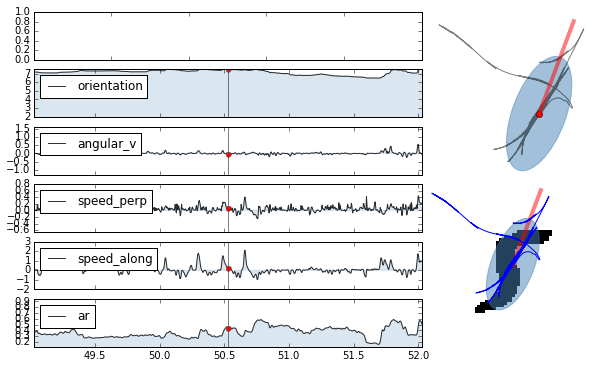

In [16]:
###### initialize figure
fig_mpl = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(6, 10)
r = 7
ax0 = plt.subplot(gs[0, :r])
ax1 = plt.subplot(gs[1, :r]) #, sharex=ax0)
ax2 = plt.subplot(gs[2, :r]) #, sharex=ax0)
ax3 = plt.subplot(gs[3, :r]) #, sharex=ax0)
ax4 = plt.subplot(gs[4, :r]) #, sharex=ax0)
ax5 = plt.subplot(gs[5, :r]) #, sharex=ax0)

# prepare initial data
row = df.loc[0]
width = row['length']
height = row['width']
angle = row['angle'] * 180. / np.pi
orr = row['orientation']

buffer = (len(contours2[0]) - 1) / 2.0

############ PATH ############
ax6 = plt.subplot(gs[:3, -3:])

x = np.array(df['x'])
y = np.array(df['y'])
x_range =  np.max(x) - np.min(x)
y_range =  np.max(y) - np.min(y)
rang = max([x_range, y_range]) / 1.8
x_mid = (np.min(x) + np.max(x)) / 2
y_mid = (np.min(y) + np.max(y)) / 2
ax6.plot(x, y, 'k', alpha=0.5)
ax6.set_ylim((y_mid - rang, y_mid + rang))
ax6.set_xlim((x_mid - rang, x_mid + rang))
path_point, = ax6.plot([x[0]], [y[0]], 'o', color='red')
e2 = Elipse(xy=(x[0], y[0]), width=width, height=height, 
           angle=angle, alpha=0.5, color='steelblue')
ax6.add_artist(e2)
orientation_line2, = ax6.plot([x[0], x[0] + buffer*np.cos(orr)], 
                              [y[0], y[0] + buffer*np.sin(orr)], lw=4, color='red', alpha=0.5)

############ SHAPE ############

ax7 = plt.subplot(gs[3:, -3:])

box_min, box_max = 0, len(contours2[0])



# add worm image
worm_im = ax7.imshow(contours2[0], interpolation='nearest', origin='lower', cmap=mpl.cm.Greys)
# draw elipse
e = Elipse(xy=(buffer+1, buffer+1), width=width, height=height, 
           angle=angle, alpha=0.5, color='steelblue')
ax7.add_artist(e)
# add orientation vector
ox = [1 + buffer, buffer*np.cos(orr)+buffer+1]
oy = [1 + buffer, buffer*np.sin(orr)+buffer+1]
ax7.plot(ox[:1], oy[:1], 'o', color='red', alpha=0.5)
orientation_line, = ax7.plot(ox, oy, lw=4, color='red', alpha=0.5)

shape_path_x = np.array(df['x'])
shape_path_y = np.array(df['y'])
shape_path, = ax7.plot(shape_path_x - x[0] + 1 + buffer, shape_path_y - y[0] + 1 + buffer)
ax7.set_ylim([box_min, box_max])
ax7.set_xlim([box_min, box_max])


############ Time ############
time_axes = [ax0, ax1, ax2, ax3, ax4, ax5]
time_cols = ['orientation', 'angular_v', 'speed_perp', 'speed_along', 'ar']

time_window = 3 # minutes

now_row = df.iloc[0]
t_now = now_row['minutes']
t0, tN = t_now - time_window / 2.0, t_now + time_window / 2.0

d = df[(df['minutes'] >= t0) & (df['minutes'] <= tN)]
p_lines = []
p_dots = []
vert_bars = []

for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.xaxis.set_ticklabels([])

for ax, col in zip(time_axes[1:], time_cols):
    ax.legend()
    ymin = np.nanmin(np.array(d[col]))
    ymax = np.nanmax(np.array(d[col]))
    vert_bar, = ax.plot([t_now, t_now], [ymin, ymax], color='k', lw=0.5)
    ax.set_ylim([ymin, ymax])
    p_line, = ax.plot(df['minutes'], df[col], alpha=0.8, color='k', label=col)
    ax.fill_between(df['minutes'], df[col],0, alpha=0.2, color='steelblue')

    p_dot, = ax.plot([t_now], [now_row[col]], '.', color='red', markersize=10, markeredgecolor='darkslategrey')
    p_lines.append(p_line)
    p_dots.append(p_dot)
    vert_bars.append(vert_bar)
    legend = ax.legend(loc='upper left')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    #ax.yaxis.set_ticklabels([])

#p1_line, p2_line, p3_line, p4_line, p5_line = p_lines
p1_dot, p2_dot, p3_dot, p4_dot, p5_dot = p_dots
v1, v2, v3, v4, v5 = vert_bars

fps = 30

def updatefig(i):

    i = int(i *fps) #moviepy
    
    global df, contours2
    # Get most recent data
    now_row = df.iloc[i]
    if i % 10 == 0:
        print(i)
    t_now = now_row['minutes']
    t0, tN = t_now - time_window / 2.0, t_now + time_window / 2.0
    orr = now_row['orientation']
    
    #### Timeseries Axis
    for col, v, p_dot in zip(time_cols, vert_bars, p_dots):
        # move the red dot
        p_dot.set_data([t_now], [now_row[col]])
        # slide the entire axis along x
        p_dot.axes.set_xlim(t0, tN) 
        # redraw the vertical 'Now' line.
        ymin = np.nanmin(np.array(d[col]))
        ymax = np.nanmax(np.array(d[col]))
        v.set_data([t_now, t_now], [ymin, ymax])
        
    #     for ax in time_axes:
    #         ax.set_xlim([t0, tN])


    
    #### path frame
    path_point.set_data([now_row['x']],[now_row['y']])
    e2.center = (float(now_row['x']), float(now_row['y']))
    e2.width = now_row['length']
    e2.height = now_row['width']
    e2.angle = now_row['angle'] * 180. / np.pi    
    #e2.y = float(now_row['y'])
    orientation_line2.set_data([now_row['x'], now_row['x'] + buffer*np.cos(orr)], 
                               [now_row['y'], now_row['y'] + buffer*np.sin(orr)])

    #### shape frame
    #     x = box_max - (now_row['x'] % grid_space)
    #     y = box_max - (now_row['y'] % grid_space)
    #     y1.set_data([box_min, box_max], [y, y])
    #     y2.set_data([box_min, box_max], [y-grid_space, y-grid_space])
    #     y3.set_data([box_min, box_max], [y-2*grid_space, y-2*grid_space])

    #     x1.set_data([x, x], [box_min, box_max])
    #     x2.set_data([x-grid_space, x-grid_space], [box_min, box_max])
    #     x3.set_data([x-2*grid_space, x-2*grid_space], [box_min, box_max])
    
    # reshape elipse
    e.width = now_row['length']
    e.height = now_row['width']
    e.angle = now_row['angle'] * 180. / np.pi
    
    # reshape orientation line
    ox = [1 + buffer, buffer*np.cos(orr)+buffer+1]
    oy = [1 + buffer, buffer*np.sin(orr)+buffer+1]
    orientation_line.set_data(ox, oy)
    
    # reshape binary worm image
    worm_im.set_array(contours2[i])
    
    
    shape_path.set_data(shape_path_x - now_row['x'] + 1 + buffer, shape_path_y - now_row['y'] + 1 + buffer)
    
    
    #     return (v1, v2, v3, v4, v5, 
    #             p1_dot, p2_dot, p3_dot, p4_dot, p5_dot, 
    #             worm_im, e, orientation_line,
    #             x1, x2, x3, y1, y2, y3,
    #             path_point, e2, orientation_line2)
    
    return mplfig_to_npimage(fig_mpl) # Moviepy

ax6.axis('off')
ax7.axis('off')

#plt.show()len(df) -1
# ani = animation.FuncAnimation(fig_mpl, updatefig,  frames=len(df)-1, blit=False, interval=2000,)
# ani.save('t2.mp4', writer=writer)

n_frames = len(df)-1
n_frames = 1
duration = n_frames * fps
animation = mpy.VideoClip(updatefig, duration=duration)
#animation.write_gif("sinc_mpl.gif", fps=10)
animation.write_videofile("movie2.mp4", fps=fps) # default codec: 'libx264', 24 fps

0
[MoviePy] >>>> Building video movie.mp4
[MoviePy] Writing video movie.mp4
|----------| 0/901   0% [elapsed: 00:00 left: ?, ? iters/sec]0
|----------| 6/901   0% [elapsed: 00:00 left: 01:16, 11.67 iters/sec]10
|----------| 18/901   1% [elapsed: 00:01 left: 01:22, 10.77 iters/sec]20
|----------| 24/901   2% [elapsed: 00:02 left: 01:20, 10.84 iters/sec]30
|----------| 31/901   3% [elapsed: 00:02 left: 01:17, 11.17 iters/sec]30
|----------| 38/901   4% [elapsed: 00:03 left: 01:15, 11.36 iters/sec]40
|----------| 45/901   4% [elapsed: 00:03 left: 01:14, 11.55 iters/sec]50
|----------| 59/901   6% [elapsed: 00:04 left: 01:11, 11.81 iters/sec]60
|----------| 66/901   7% [elapsed: 00:05 left: 01:10, 11.91 iters/sec]70
|----------| 80/901   8% [elapsed: 00:06 left: 01:08, 12.05 iters/sec]80
|----------| 87/901   9% [elapsed: 00:07 left: 01:07, 12.10 iters/sec]90
|#---------| 94/901  10% [elapsed: 00:07 left: 01:06, 12.15 iters/sec]100
|#---------| 108/901  11% [elapsed: 00:08 left: 01:04, 12.

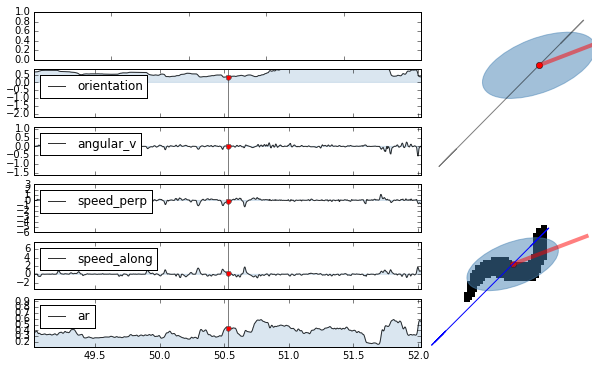

In [95]:
# df = df.copy()
# x = df['x']
# y = df['y']
# df['y'] = x
# df['x'] = y

###### initialize figure
fig_mpl = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(6, 10)
r = 7
ax0 = plt.subplot(gs[0, :r])
ax1 = plt.subplot(gs[1, :r]) #, sharex=ax0)
ax2 = plt.subplot(gs[2, :r]) #, sharex=ax0)
ax3 = plt.subplot(gs[3, :r]) #, sharex=ax0)
ax4 = plt.subplot(gs[4, :r]) #, sharex=ax0)
ax5 = plt.subplot(gs[5, :r]) #, sharex=ax0)

# prepare initial data
row = df.loc[0]
width = row['length']
height = row['width']
angle = row['angle'] * 180. / np.pi
orr = row['orientation']

buffer = (len(contours2[0]) - 1) / 2.0

############ PATH ############
ax6 = plt.subplot(gs[:3, -3:])

x = np.array(df['x'])
y = np.array(df['y'])
x_range =  np.max(x) - np.min(x)
y_range =  np.max(y) - np.min(y)
rang = max([x_range, y_range]) / 1.8
x_mid = (np.min(x) + np.max(x)) / 2
y_mid = (np.min(y) + np.max(y)) / 2
ax6.plot(x, y, 'k', alpha=0.5)
ax6.set_ylim((y_mid - rang, y_mid + rang))
ax6.set_xlim((x_mid - rang, x_mid + rang))
path_point, = ax6.plot([x[0]], [y[0]], 'o', color='red')
e2 = Elipse(xy=(x[0], y[0]), width=width, height=height, 
           angle=angle, alpha=0.5, color='steelblue')
ax6.add_artist(e2)
orientation_line2, = ax6.plot([x[0], x[0] + buffer*np.cos(orr)], 
                              [y[0], y[0] + buffer*np.sin(orr)], lw=4, color='red', alpha=0.5)

############ SHAPE ############

ax7 = plt.subplot(gs[3:, -3:])

box_min, box_max = 0, len(contours2[0])



# add worm image
worm_im = ax7.imshow(contours2[0], interpolation='nearest', origin='lower', cmap=mpl.cm.Greys)
# draw elipse
e = Elipse(xy=(buffer+1, buffer+1), width=width, height=height, 
           angle=angle, alpha=0.5, color='steelblue')
ax7.add_artist(e)
# add orientation vector
ox = [1 + buffer, buffer*np.cos(orr)+buffer+1]
oy = [1 + buffer, buffer*np.sin(orr)+buffer+1]
ax7.plot(ox[:1], oy[:1], 'o', color='red', alpha=0.5)
orientation_line, = ax7.plot(ox, oy, lw=4, color='red', alpha=0.5)

shape_path_x = np.array(df['x'])
shape_path_y = np.array(df['y'])
shape_path, = ax7.plot(shape_path_x - x[0] + 1 + buffer, shape_path_y - y[0] + 1 + buffer)
ax7.set_ylim([box_min, box_max])
ax7.set_xlim([box_min, box_max])


############ Time ############
time_axes = [ax0, ax1, ax2, ax3, ax4, ax5]
time_cols = ['orientation', 'angular_v', 'speed_perp', 'speed_along', 'ar']

time_window = 3 # minutes

now_row = df.iloc[0]
t_now = now_row['minutes']
t0, tN = t_now - time_window / 2.0, t_now + time_window / 2.0

d = df[(df['minutes'] >= t0) & (df['minutes'] <= tN)]
p_lines = []
p_dots = []
vert_bars = []

for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.xaxis.set_ticklabels([])

for ax, col in zip(time_axes[1:], time_cols):
    ax.legend()
    ymin = np.nanmin(np.array(d[col]))
    ymax = np.nanmax(np.array(d[col]))
    vert_bar, = ax.plot([t_now, t_now], [ymin, ymax], color='k', lw=0.5)
    ax.set_ylim([ymin, ymax])
    p_line, = ax.plot(df['minutes'], df[col], alpha=0.8, color='k', label=col)
    ax.fill_between(df['minutes'], df[col],0, alpha=0.2, color='steelblue')

    p_dot, = ax.plot([t_now], [now_row[col]], '.', color='red', markersize=10, markeredgecolor='darkslategrey')
    p_lines.append(p_line)
    p_dots.append(p_dot)
    vert_bars.append(vert_bar)
    legend = ax.legend(loc='upper left')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    #ax.yaxis.set_ticklabels([])

#p1_line, p2_line, p3_line, p4_line, p5_line = p_lines
p1_dot, p2_dot, p3_dot, p4_dot, p5_dot = p_dots
v1, v2, v3, v4, v5 = vert_bars

fps = 30

def updatefig(i):

    i = int(i *fps) #moviepy
    
    global df, contours2
    # Get most recent data
    now_row = df.iloc[i]
    if i % 10 == 0:
        print(i)
    t_now = now_row['minutes']
    t0, tN = t_now - time_window / 2.0, t_now + time_window / 2.0
    orr = now_row['orientation']
    
    #### Timeseries Axis
    for col, v, p_dot in zip(time_cols, vert_bars, p_dots):
        # move the red dot
        p_dot.set_data([t_now], [now_row[col]])
        # slide the entire axis along x
        p_dot.axes.set_xlim(t0, tN) 
        # redraw the vertical 'Now' line.
        ymin = np.nanmin(np.array(d[col]))
        ymax = np.nanmax(np.array(d[col]))
        v.set_data([t_now, t_now], [ymin, ymax])
        
    #     for ax in time_axes:
    #         ax.set_xlim([t0, tN])


    
    #### path frame
    path_point.set_data([now_row['x']],[now_row['y']])
    e2.center = (float(now_row['x']), float(now_row['y']))
    e2.width = now_row['length']
    e2.height = now_row['width']
    e2.angle = now_row['angle'] * 180. / np.pi    
    #e2.y = float(now_row['y'])
    orientation_line2.set_data([now_row['x'], now_row['x'] + buffer*np.cos(orr)], 
                               [now_row['y'], now_row['y'] + buffer*np.sin(orr)])

    #### shape frame
    #     x = box_max - (now_row['x'] % grid_space)
    #     y = box_max - (now_row['y'] % grid_space)
    #     y1.set_data([box_min, box_max], [y, y])
    #     y2.set_data([box_min, box_max], [y-grid_space, y-grid_space])
    #     y3.set_data([box_min, box_max], [y-2*grid_space, y-2*grid_space])

    #     x1.set_data([x, x], [box_min, box_max])
    #     x2.set_data([x-grid_space, x-grid_space], [box_min, box_max])
    #     x3.set_data([x-2*grid_space, x-2*grid_space], [box_min, box_max])
    
    # reshape elipse
    e.width = now_row['length']
    e.height = now_row['width']
    e.angle = now_row['angle'] * 180. / np.pi
    
    # reshape orientation line
    ox = [1 + buffer, buffer*np.cos(orr)+buffer+1]
    oy = [1 + buffer, buffer*np.sin(orr)+buffer+1]
    orientation_line.set_data(ox, oy)
    
    # reshape binary worm image
    worm_im.set_array(contours2[i])
    
    
    shape_path.set_data(shape_path_x - now_row['x'] + 1 + buffer, shape_path_y - now_row['y'] + 1 + buffer)
    
    
    #     return (v1, v2, v3, v4, v5, 
    #             p1_dot, p2_dot, p3_dot, p4_dot, p5_dot, 
    #             worm_im, e, orientation_line,
    #             x1, x2, x3, y1, y2, y3,
    #             path_point, e2, orientation_line2)
    
    return mplfig_to_npimage(fig_mpl) # Moviepy

ax6.axis('off')
ax7.axis('off')

#plt.show()len(df) -1
# ani = animation.FuncAnimation(fig_mpl, updatefig,  frames=len(df)-1, blit=False, interval=2000,)
# ani.save('t2.mp4', writer=writer)

n_frames = len(df)-1
n_frames = 1
duration = n_frames * fps
animation = mpy.VideoClip(updatefig, duration=duration)
#animation.write_gif("sinc_mpl.gif", fps=10)
animation.write_videofile("movie.mp4", fps=fps) # default codec: 'libx264', 24 fps

# This Code checks if assigning pauses works properly

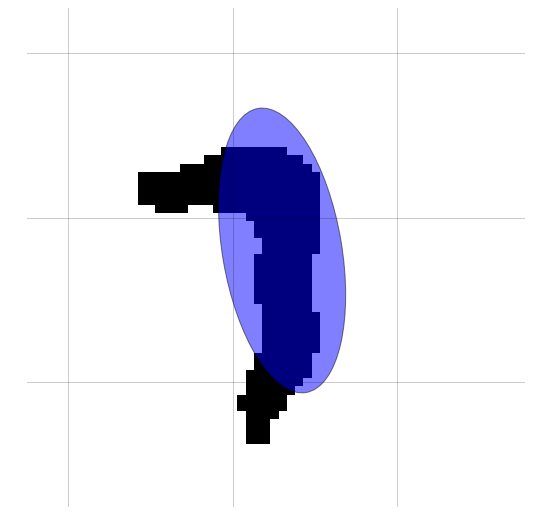

In [61]:
fig, ax = plt.subplots(figsize=(9,9))
ax.axis('off')
c = morph.binary_fill_holes(worm_shape.contours[0])
buffer = (len(c) - 1) / 2.0


i = 0
row = worm_shape.df.loc[i]
grid_space = int(len(c) / 3)
x = row['centroid_x'] % grid_space
y = row['centroid_y'] % grid_space

width = row['elipse_major']
height = row['elipse_minor']
angle = row['elipse_angle'] * 180. / np.pi

box_min, box_max = 0, len(c)
y1, = ax.plot([box_min, box_max], [y, y], 'k', alpha=0.2)
y2, = ax.plot([box_min, box_max], [y+grid_space, y+grid_space], 'k', alpha=0.2)
y3, = ax.plot([box_min, box_max], [y+2*grid_space, y+2*grid_space], 'k', alpha=0.2)

x1, = ax.plot([x, x], [box_min, box_max], 'k', alpha=0.2)
x2, = ax.plot([x+grid_space, x+grid_space], [box_min, box_max], 'k', alpha=0.2)
x3, = ax.plot([x+2*grid_space, x+2*grid_space], [box_min, box_max], 'k', alpha=0.2)

im = ax.imshow(c, interpolation='nearest', origin='lower', cmap=mpl.cm.Greys)



e = Elipse(xy=(buffer+1, buffer+1), width=width, height=height, angle=angle, alpha=0.5)
ax.add_artist(e)
#ax[0].axis('off')
con = worm_shape.contours
def updatefig(i):
    global con, e
    c = morph.binary_fill_holes(con[i])
    im.set_array(c)
    row = worm_shape.df.loc[i]
    e.width = row['elipse_major']
    e.height = row['elipse_minor']
    e.angle = row['elipse_angle'] * 180. / np.pi
    
    x = row['centroid_x'] % grid_space
    y = row['centroid_y'] % grid_space
    y1.set_data([box_min, box_max], [y, y])
    y2.set_data([box_min, box_max], [y+grid_space, y+grid_space])
    y3.set_data([box_min, box_max], [y+2*grid_space, y+2*grid_space])

    x1.set_data([x, x], [box_min, box_max])
    x2.set_data([x+grid_space, x+grid_space], [box_min, box_max])
    x3.set_data([x+2*grid_space, x+2*grid_space], [box_min, box_max])

    return im, e, y1, y2, x1, x2

#interval: interval draws a new frame every interval milliseconds
ani = animation.FuncAnimation(fig, updatefig,  frames=500, blit=True) #interval=len(contours),
ani.save('im.mp4', writer=writer)

/Users/peterwinter/.pyenv/versions/3.4.1/lib/python3.4/site-packages/pandas/core/indexing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/peterwinter/.pyenv/versions/3.4.1/lib/python3.4/site-packages/IPython/kernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/peterwinter/.pyenv/versions/3.4.1/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-

2851.8 3599.8


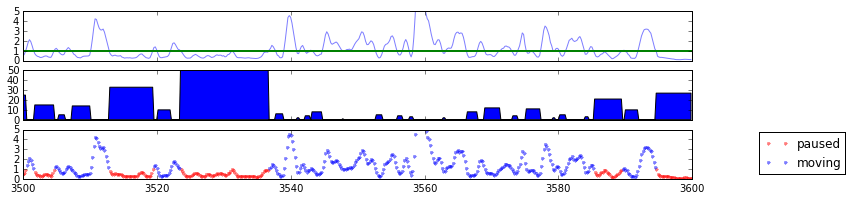

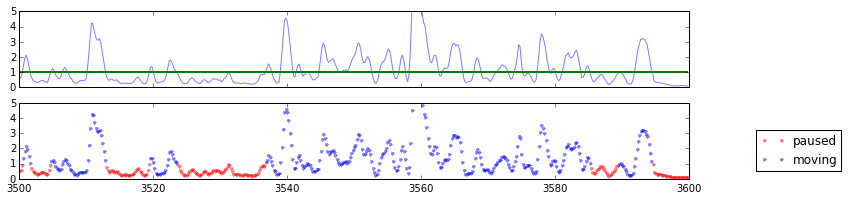

In [9]:
def show_pauses(df, ax=None):
    #counts = [1,5,10]
    if ax is None:
        fig, ax = plt.subplots(figsize=(13, 3))
    #df.plot(x='time', y='speed', color='k', alpha=0.3, ax=ax)
    paused = (df['behavior_class'] == 0)
    not_paused = (paused == False)
    #print(not_paused)

    d1 = df[paused]
    if d1 is not None and len(d1):
        ax.plot(np.array(d1['time']),np.array(d1['speed']), '.', color='red', alpha=0.8, label='paused')
        #d1.plot(kind='scatter', x='minutes', y='speed', color='red', alpha=0.8, ax=ax)
    d2 = df[not_paused]
    if d2 is not None and len(d2):
        ax.plot(np.array(d2['time']),np.array(d2['speed']), '.', color='blue', alpha=0.8, label='moving')

        #d2.plot(kind='scatter', x='minutes', y='speed', color='blue', alpha=0.8, ax=ax)
    ax.legend(loc=(1.1, 0.1))
    return ax

def assign_pauses(df, speed_cut=2.1, min_points=5):
    if 'behavior_class' not in df.columns:
        df['behavior_class'] = -1
        print('reset behavior')

    for df_part in bc.split_df(df=df):
        #print(speed_cut)
        x = np.array(df_part['speed'] < speed_cut, dtype=int)
        y = bc.count_true_values(x) 
        df_part['behavior_class'].iloc[y>= min_points] = 0

    return df_part, x, y

def basic_check(speed_cut= 1.0, min_points=10, xlim=None):
    full_df = bc.df
    d, x, y = assign_pauses(df=full_df, speed_cut=speed_cut, min_points=min_points)
    d2 = full_df.loc[d.index]

    fig, axes = plt.subplots(3, 1, figsize=(12,3), sharex=True)
    ax0, ax1, ax2 = axes

    t0 = d.iloc[0]['time']
    tn = d.iloc[-1]['time']

    print(t0, tn)
    ax0.plot(np.array(d['time']), np.array(d['speed']), alpha=0.5)
    ax0.plot([t0, tn], [speed_cut , speed_cut], lw=2)
    ax0.set_ylim([0, 5])

    ax1.fill_between(np.array(d['time']), y, 0)
    #ax1.plot(x)
    ax1.set_ylim([0, 50])
    #ax1.set_xlim([0, 500])

    bc.show_pauses(d, ax=ax2)
    ax2.set_ylim([0, 5])
    ax0.set_xlim([2900, 3599.8])
    if xlim is not None:
        ax0.set_xlim(xlim)
    # d = bc.assign_pauses(df=full_df, speed_cut=2, min_points=5)
    # fig, ax = plt.subplots(figsize=(12,3))
    # ax = bc.show_pauses(d, ax=ax)
    # ax.set_xlim([10, 25])

def from_class(speed_cut= 1.0, min_points=10, xlim=None):
    full_df = bc.df
    
    d = bc.assign_pauses(df=full_df, speed_cut=speed_cut, min_points=min_points)
    #d2, x, y = assign_pauses(df=full_df, speed_cut=speed_cut, min_points=30)
    #print(len(d1))
    #print(len(d2))

    # print(len(full_df[full_df['behavior_class'] == 0]))
    # print(len(full_df[full_df['behavior_class'] != 0]))
    # print(len(d[d['behavior_class'] == 0]))
    # print(len(d[d['behavior_class'] != 0]))
    # #print(d.head())
    fig, axes = plt.subplots(2, 1, figsize=(12,3), sharex=True)
    ax0, ax1 = axes

    t0 = d.iloc[0]['time']
    tn = d.iloc[-1]['time']

    ax0.plot(np.array(d['time']), np.array(d['speed']), alpha=0.5)
    ax0.plot([t0, tn], [speed_cut , speed_cut], lw=2)
    ax0.set_ylim([0, 5])

    bc.show_pauses(d, ax=ax1)
    ax1.set_ylim([0, 5])

    ax0.set_xlim([1200, 1500])
    ax0.set_xlim([2900, 3599.8])
    if xlim is not None:
        ax0.set_xlim(xlim)

    
speed_cut= 1.0
min_points=15
xlim = (3500, 3600)
basic_check(speed_cut, min_points, xlim)
from_class(speed_cut, min_points, xlim)

374.8 3599.8
93 assigned
15717 not assigned


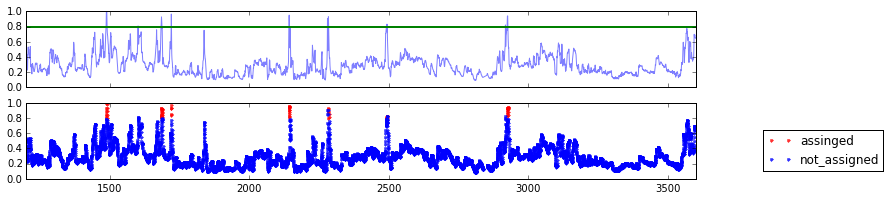

In [16]:
def show_assignment(df, plot_col='ar', assignment_col='behavior_class', assignment_value=1, ax=None):
    #counts = [1,5,10]
    if ax is None:
        fig, ax = plt.subplots(figsize=(13, 3))
    #df.plot(x='time', y='speed', color='k', alpha=0.3, ax=ax)
    assigned = (df[assignment_col] == assignment_value)
    print(np.sum(assigned), 'assigned')
    not_assingned = (assigned == False)
    print(np.sum(not_assingned), 'not assigned')

    #print(not_paused)

    d1 = df[assigned]
    if d1 is not None and len(d1):
        ax.plot(np.array(d1['time']),np.array(d1[plot_col]), '.', color='red', alpha=0.8, label='assinged')
        #d1.plot(kind='scatter', x='minutes', y='speed', color='red', alpha=0.8, ax=ax)
    d2 = df[not_assingned]
    if d2 is not None and len(d2):
        ax.plot(np.array(d2['time']),np.array(d2[plot_col]), '.', color='blue', alpha=0.8, label='not_assigned')

        #d2.plot(kind='scatter', x='minutes', y='speed', color='blue', alpha=0.8, ax=ax)
    ax.legend(loc=(1.1, 0.1))
    return ax  


# def assign_coils(df, ar_cut=0.8, min_points=5):
#     return bc._assign_behavior(df, 
#                            col_name='ar', 
#                            value_cuttoff=ar_cut, 
#                            operation='>', 
#                            min_points=5, 
#                            assignment_col='behavior_class', 
#                            assignment_value=1)


def basic_check(ar_cut=0.8, min_points=10, xlim=None):
    full_df = bc.df
    d = bc.assign_coils(df=full_df, ar_cut=ar_cut, min_points=min_points)
    d2 = full_df.loc[d.index]

    fig, axes = plt.subplots(2, 1, figsize=(12,3), sharex=True)
    ax0, ax1 = axes

    t0 = d.iloc[0]['time']
    tn = d.iloc[-1]['time']

    print(t0, tn)
    ax0.plot(np.array(d['time']), np.array(d['ar']), alpha=0.5)
    ax0.plot([t0, tn], [ar_cut , ar_cut], lw=2)
    ax0.set_ylim([0, 1])

    #ax1.fill_between(np.array(d['time']), y, 0)
    #ax1.plot(x)
    ax1.set_ylim([0, 5])
    #ax1.set_xlim([0, 500])

    bc._show_assignment(d, ax=ax1)
    ax1.set_ylim([0, 1])
    #ax0.set_xlim([2900, 3599.8])
    if xlim is not None:
        ax0.set_xlim(xlim)
    # d = bc.assign_pauses(df=full_df, speed_cut=2, min_points=5)
    # fig, ax = plt.subplots(figsize=(12,3))
    # ax = bc.show_pauses(d, ax=ax)
    # ax.set_xlim([10, 25])

def from_class(speed_cut= 1.0, min_points=10, xlim=None):
    pass

ar_cut= 0.8
min_points=5
xlim = (1200, 3600)
#xlim = (1480, 1550)
#xlim = (2100, 2300)

basic_check(ar_cut, min_points, xlim)
from_class(ar_cut, min_points, xlim)

# TODO

I have coils found
I have 
mark pauses.

NEED:
means of pulling out start and ends of periods.
use the count thing. max = one end. min >=0 is other end.

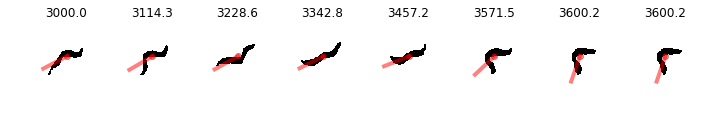

In [12]:
def show_shape(t, worm_shape=worm_shape, ax=None):
    wdf = worm_shape.df
    dt = np.abs(wdf['time'] - t)
    index_of_nearest = np.argsort(dt)[0]
    row = wdf.iloc[index_of_nearest]
    time = round(row['time'], ndigits=1)
    c = morph.binary_fill_holes(worm_shape.contours[index_of_nearest])
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(c, interpolation='nearest', cmap=mpl.cm.Greys, origin='lower')
    ax.axis('off')
    ax.set_title(time)
    
def draw_orientation(t, df, buffer, ax=None):
    dt = np.abs(np.array(df['time'] - t))
    index_of_nearest = np.argsort(dt)[0]
    row = df.iloc[index_of_nearest]

    orr = row['orientation']
    x = [1 + buffer, buffer*np.cos(orr)+buffer+1]
    y = [1 + buffer, buffer*np.sin(orr)+buffer+1]
    ax.plot(x[:1], y[:1], 'o', color='red', alpha=0.5)
    ax.plot(x, y, lw=4, color='red', alpha=0.5)
    
def show_shapes(ts, worm_shape=worm_shape, df=None):
    n = len(ts)
    fig, axs = plt.subplots(1, n, figsize=(12, 3))
    buffer = worm_shape.buffer_size
    for t, ax in zip(ts, axs):
        show_shape(t, worm_shape=worm_shape, ax=ax)
        if df is not None:
            draw_orientation(t, df, buffer=buffer, ax=ax)
    plt.show()
    
#t = 3650    
#show_shape(t)
ts = np.linspace(3000, 3800, 8)
show_shapes(ts=ts, df=bc.df)

In [34]:
df.head()

,index,time,frame,x,y,length,width,len_x,len_y,angle,...,speed_perp,speed_along,std_length,d_angle,angular_v,ar,std_ar,minutes,behavior_class,move_dir
0,0,2851.8,42916,1050.933264,755.980339,47.743802,7.638017,-8.172669,6.146033,-0.949660,...,-0.535302,1.347904,0.091215,0.002228,0.035631,0.160018,14.109403,47.530000,-1,-1
1,1,2852.0,42919,1050.933264,755.980339,47.743802,7.638017,-8.172669,6.146033,-0.922262,...,-0.535302,1.347904,0.091215,0.002228,0.035631,0.160018,14.109403,47.533333,-1,-1
2,2,2852.2,42922,1051.148521,755.848355,47.419421,7.707438,-8.166054,6.221326,-0.913946,...,-0.600565,1.582199,0.109319,0.002707,0.042172,0.162595,14.109403,47.536667,-1,-1
3,3,2852.4,42925,1051.613822,755.551876,46.728099,7.879752,-8.155603,6.393682,-0.915101,...,-0.731089,2.162103,0.151088,0.003748,0.057009,0.168678,14.172343,47.540000,-1,-1
4,4,2852.6,42928,1051.844620,755.391884,46.524380,7.985537,-8.157818,6.486897,-0.894458,...,-0.589308,1.945919,0.136458,0.003363,0.050581,0.171670,15.431781,47.543333,-1,-1


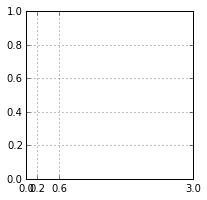

In [46]:
#fig, ax = plt.subplots(figsize=(10, 3))
#df[['angle', 'orientation']] #.plot(ax = ax)
fig, ax = plt.subplots(figsize=(3,3))
ax.grid(True)
ax.set_xticks([0, 0.2, 0.6])

In [45]:
worm_shape.df.columns

Index([u'frame', u'time', u'centroid_x', u'centroid_y', u'contour_x', u'contour_y', u'elipse_angle', u'elipse_major', u'elipse_minor', u'center_shift_x', u'center_shift_y', u'x_max', u'x_min', u'y_max', u'y_min'], dtype='object')

0
0
100
200
300
400


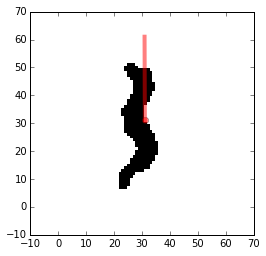

In [28]:
fig, ax = plt.subplots()
df = bc.df
c = contours2[0]
im = ax.imshow(c, interpolation='nearest', origin='lower', cmap=mpl.cm.Greys)
#ax.axis('off')
buffer = (c.shape[1] -1 ) / 2
row = df.iloc[0]
orr = row['orientation']
x = [1 + buffer, buffer*np.cos(orr)+buffer+1]
y = [1 + buffer, buffer*np.sin(orr)+buffer+1]
p_dot, = ax.plot(x[:1], y[:1], 'o', color='red', alpha=0.5)
p_line, = ax.plot(x, y, lw=4, color='red', alpha=0.5)

def updatefig(i):
    global contours2, df
    if i % 100 == 0:
        print(i)
    # update the image
    im.set_array(contours2[i])
    
    # update the orientation line
    row = df.iloc[i]
    orr = row['orientation']
    x = [1 + buffer, buffer*np.cos(orr)+buffer+1]
    y = [1 + buffer, buffer*np.sin(orr)+buffer+1]
    p_dot.set_data(x[:1], y[:1])
    p_line.set_data(x, y)
    return im, p_dot, p_line,
#interval: interval draws a new frame every interval milliseconds
ani = animation.FuncAnimation(fig, updatefig,  frames=500, blit=True) #interval=len(contours),
ani.save('shape.mp4', writer=writer)

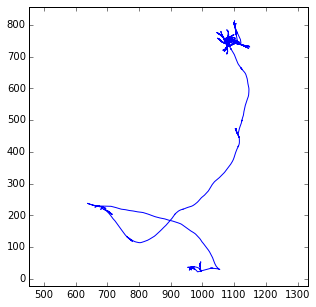

In [39]:
df = bc.df.copy() #df_list[4].copy()

def plot_path(df, ax):


fig, ax = plt.subplots(figsize=(5,5))
plot_path(df, ax)
plt.show()

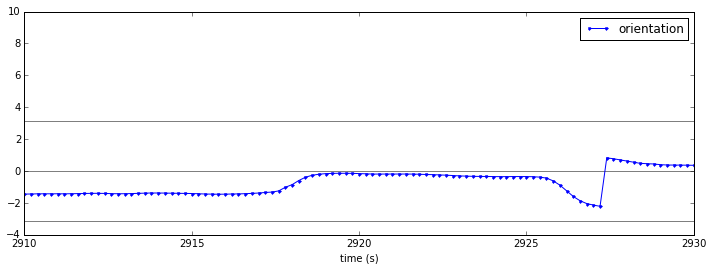

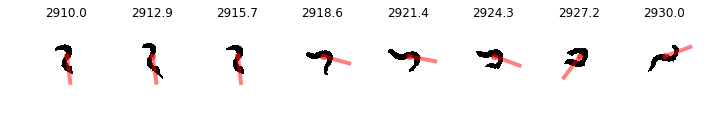

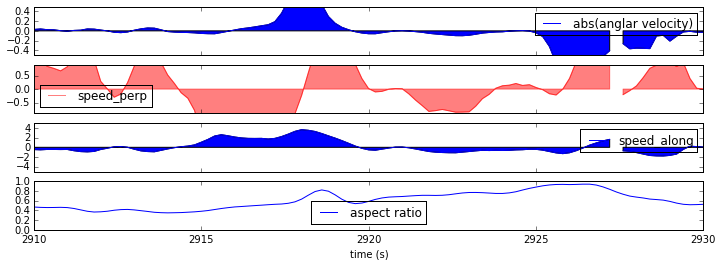

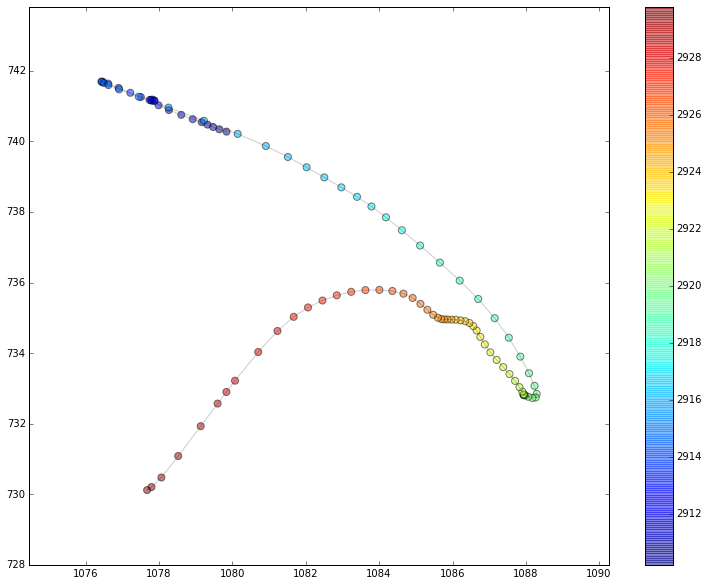

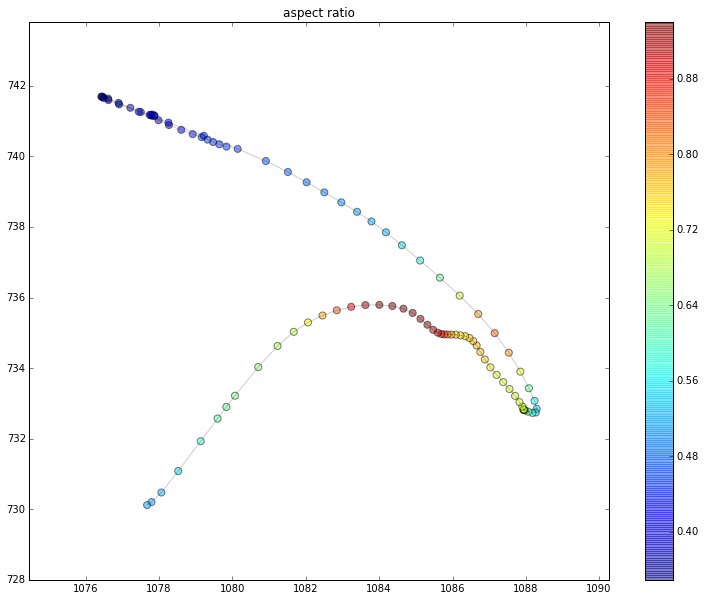

In [29]:
#df_list = bc.split_df()
df = bc.df.copy() #df_list[4].copy()
x_start, x_end = 2910, 2950
x_start, x_end = 2910, 2930
#x_start, x_end = 2890, 2900
#x_start, x_end = 3550, 3600
#x_start, x_end = 3000, 3100
#x_start, x_end = 2830, 2860

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df['time'], [np.pi for _ in range(len(df))], 'k', alpha=0.5)
ax.plot(df['time'], [0 for _ in range(len(df))], 'k', alpha=0.5)
ax.plot(df['time'], [-np.pi for _ in range(len(df))], 'k', alpha=0.5)

ax.plot(df['time'], df['orientation'], '.-', label='orientation')
ax.legend(loc='best')
ax.set_xlim([x_start, x_end])
ax.set_xlabel('time (s)')
plt.show()

ts = np.linspace(x_start, x_end, 8)
show_shapes(ts=ts, df=df)

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 4))
ax[0].fill_between(df['time'], df['angular_v'], 0, label='abs(anglar velocity)')
ax[0].plot(df['time'], df['angular_v'], label='abs(anglar velocity)')

ax[1].fill_between(df['time'], df['speed_perp'], 0, alpha=0.5, color='red')
ax[1].plot(df['time'], df['speed_perp'], label='speed_perp', alpha=0.5, color='red')

ax[2].fill_between(df['time'], df['speed_along'], 0)
ax[2].plot(df['time'], df['speed_along'], label='speed_along')



#ax[1].plot(df['time'], df['speed_along'], '.-',label='speed_along')
#ax[2].plot(df['time'], df['speed_perp'], '.-',label='speed_perp')
ax[3].plot(df['time'], df['ar'], '-', label='aspect ratio')
#ax[2].plot(df['time'], df['std_length'], '.-',label='std_length')

#ax.plot(df['time'], df['orientation2'],  lw=4,label='o2')
#ax[0].set_xlim([2910, 2930])
#ax[0].set_xlim([2850, 2930])
#ax[0].set_xlim([3550, 3600])
ax[0].set_xlim([x_start, x_end])

ax[0].set_ylim([-0.5, 0.5])
ax[1].set_ylim([-0.9, 0.9])
ax[2].set_ylim([-5, 5])
ax[3].set_ylim([0.0, 1.0])
ax[-1].set_xlabel('time (s)')

for a in ax:
    a.legend(loc='best')
plt.show()

#############

fig, ax = plt.subplots(figsize=(6.5*2, 5*2))
sub_df = df[(df['time'] > x_start) & (df['time'] < x_end)]
x_range =  max(sub_df['x']) - min(sub_df['x'])
y_range =  max(sub_df['y']) - min(sub_df['y'])
rang = np.max([x_range, y_range])
x_mid = (max(sub_df['x']) + min(sub_df['x'])) / 2.0
y_mid = (max(sub_df['y']) + min(sub_df['y'])) / 2.0
ax.plot(sub_df['x'], sub_df['y'], color='k', alpha=0.2)
sc = ax.scatter(sub_df['x'], sub_df['y'], c=sub_df['time'], s=50, alpha=0.5)
cb = plt.colorbar(sc)
ax.set_xlim([x_mid - rang / 1.5, x_mid + rang/ 1.5])
ax.set_ylim([y_mid - rang / 1.5, y_mid + rang/ 1.5])
plt.show()

#############

fig, ax = plt.subplots(figsize=(6.5*2, 5*2))
sub_df = df[(df['time'] > x_start) & (df['time'] < x_end)]
x_range =  max(sub_df['x']) - min(sub_df['x'])
y_range =  max(sub_df['y']) - min(sub_df['y'])
rang = np.max([x_range, y_range])
x_mid = (max(sub_df['x']) + min(sub_df['x'])) / 2.0
y_mid = (max(sub_df['y']) + min(sub_df['y'])) / 2.0
ax.plot(sub_df['x'], sub_df['y'], color='k', alpha=0.2)
sc = ax.scatter(sub_df['x'], sub_df['y'], c=sub_df['ar'], s=50, alpha=0.5) # 'orientation'
cb = plt.colorbar(sc)
ax.set_xlim([x_mid - rang / 1.5, x_mid + rang/ 1.5])
ax.set_ylim([y_mid - rang / 1.5, y_mid + rang/ 1.5])
ax.set_title('aspect ratio')
plt.show()

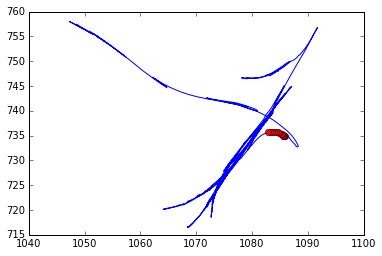

In [275]:
d = df.copy()
d = d[d['ar']    > 0.8]
d = d[d['speed'] < 3.0]

# print(len(d))
# fig, ax = plt.subplots()
# ax.hist(np.array(d['speed']), normed=True)
# ax.hist(np.array(df['speed']), normed=True, alpha=0.5, bins=50)
# ts = random.sample(list(d['time']), 10)
# show_shapes(ts=ts, df=df)

x, y = zip(*np.array(df[['x', 'y']]))
px, py = zip(*np.array(d[['x', 'y']]))

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(px, py, 'o', color='red')
plt.show()
                       

# ts = random.sample(list(d['time']), 10)
# show_shapes(ts=ts, df=df)
# ts = random.sample(list(d['time']), 10)
# show_shapes(ts=ts, df=df)

In [271]:
df = bc.df.copy()
df_list = bc.split_df(df)
print(len(df_list))
df = df_list[4]
print(len(df))


5
3741


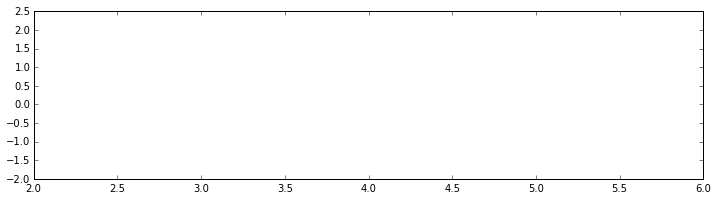

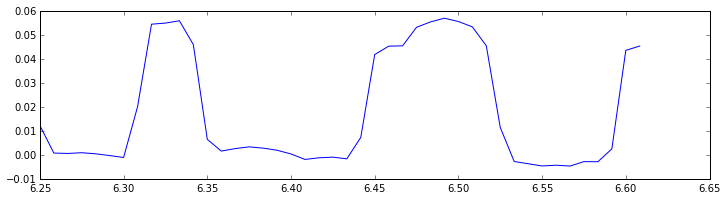

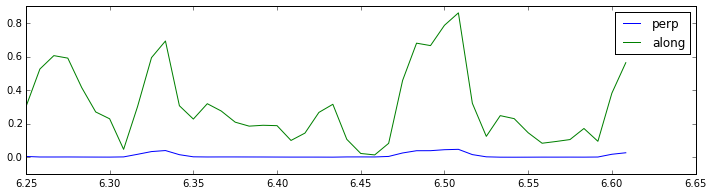

In [70]:
df = bc.df.copy()
df = bc.split_df(df)[0]

move_xy = np.array(df[['dx', 'dy']])
move_d = np.sqrt(df['dx']**2 + df['dy']**2)
or_xy = np.array(df[['len_x', 'len_y']])

theta = (df['orientation'] - df['move_or']) * np.pi / 180
perp = move_d * np.sin(theta)
along = move_d * np.cos(theta)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df['minutes'], df['orientation'])
ax.plot(df['minutes'], df['move_or'])
#
ax.set_xlim([2,6])
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df['minutes'], theta)
#ax.set_xlim([1, 1.5])
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df['minutes'], perp, label='perp')
ax.plot(df['minutes'], along, label='along')
ax.legend()
#ax.set_xlim([1, 1.5])
plt.show()

745
speed


/Users/peterwinter/.pyenv/versions/3.4.1/lib/python3.4/site-packages/pandas/tools/plotting.py:3218: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  "is being cleared", UserWarning)


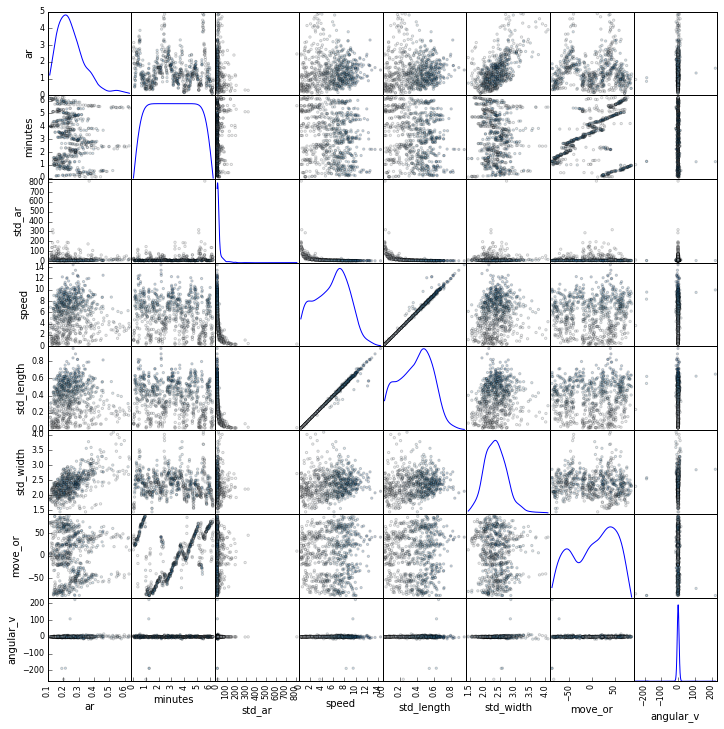

In [77]:
cols= [ 'ar',
        'minutes',
        #'x', 'y',
        'std_ar',
        'speed',
        #'orientation',
        'std_length',
        'std_width',
        'move_or',
        'angular_v']

#df = bc.df.copy()
#df = df[df['minutes'] < 30]
#df = df[df['minutes'] > 20]
print(len(df))
#rows = random.sample(list(df.index), 500)
#rows = list(df.index)[::50]
#print(len(rows))
#df = df.loc[rows]
fig = plt.figure(figsize=(12,12))
ax = plt.subplot()
#df.plot(kind='scatter', x='std_width', c='ar', y='speed', cmap=mpl.cm.Reds, alpha=0.1, ax=ax)
color_col = 'speed'
ax = pd.scatter_matrix(df[cols], c=df[color_col], 
                       cmap=mpl.cm.Blues,
                       alpha=0.2, figsize=(12, 12), diagonal='kde', ax=ax)
print(color_col)
plt.show()

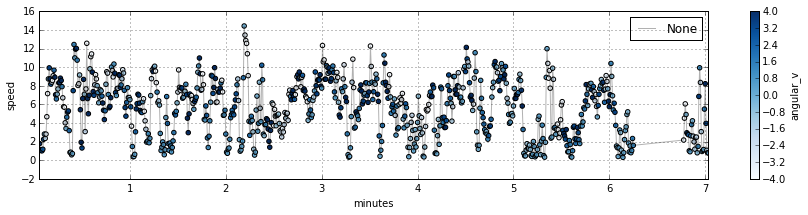

In [78]:
cols= ['ar',
'speed',
'orientation',
'std_length',
'std_width',
'move_or',
'angular_v']

df = bc.df[bc.df['behavior_class'] == -1]
#df_list = bc.split_df(df, max_gap_seconds=1)
#df = df_list[1]

fig, ax = plt.subplots(figsize=(15, 3))
df.plot(x='minutes', y='speed', ax=ax, color='k', alpha=0.3)
df.plot(kind='scatter', x='minutes', y='speed', c='angular_v', ax=ax, vmax=4, vmin=-4, cmap=mpl.cm.Blues)
plt.show()

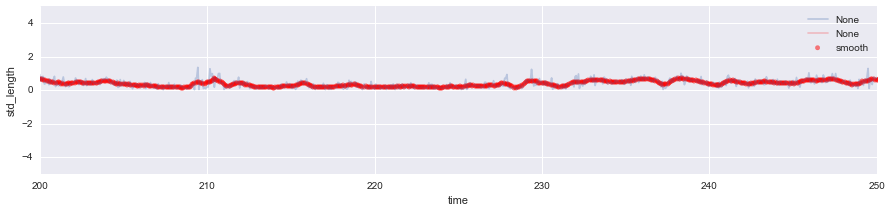

In [61]:
df = bc.df
df_raw = bc.calculate_columns_df(df=bc.raw_df)
#for df in df_list:
#plt.plot(df['minutes'], df['speed'])
#df['hey'] = pd.rolling_mean(df['move_dir'],10, center=True) - df['orientation']
#col = 'speed'
col = 'move_or'
#col = 'orientation'
#col = 'angular_v'
col = 'ar'
col = 'std_ar'
col = 'std_width'
col = 'std_length'

#col = 'x'
#col = 'length'
#col = 'width'
#col = 'vx'
fig, ax = plt.subplots(figsize=(15, 3))
df_raw.plot( x='time', y=col,  alpha=0.3, ax=ax)
df.plot(x='time', y=col, color='red', alpha=0.2, ax=ax)
#df_raw.plot(kind='scatter', x='time', y=col,  alpha=0.7, ax=ax, label='raw')
df.plot(kind='scatter',x='time', y=col, color='red', alpha=0.5, ax=ax, label='smooth')

#pd.rolling_mean(df_raw, 10, center=True).plot( x='time', y=col,  alpha=0.3, ax=ax)
#pd.rolling_mean(df_raw, 10, center=True).plot(x='time', y=col, color='orange', alpha=0.2, ax=ax, label='smooth2')

#ax.plot(df['minutes'], df['hey'])
#ax.set_xlim([200, 250])
ax.set_ylim([-5, 5])
#ax.set_ylim([0, 30])
#ax.set_ylim([1, 5])

ax.set_xlim([200, 250])
#ax.set_xlim([392, 400])
#ax.set_xlim([295, 305])
#ax.set_ylim([720, 765])
plt.show()

In [62]:
# df = bc.df.copy()
# df.plot(kind='scatter', x='x', y='y', alpha=0.5)
# plt.show()

angular_v


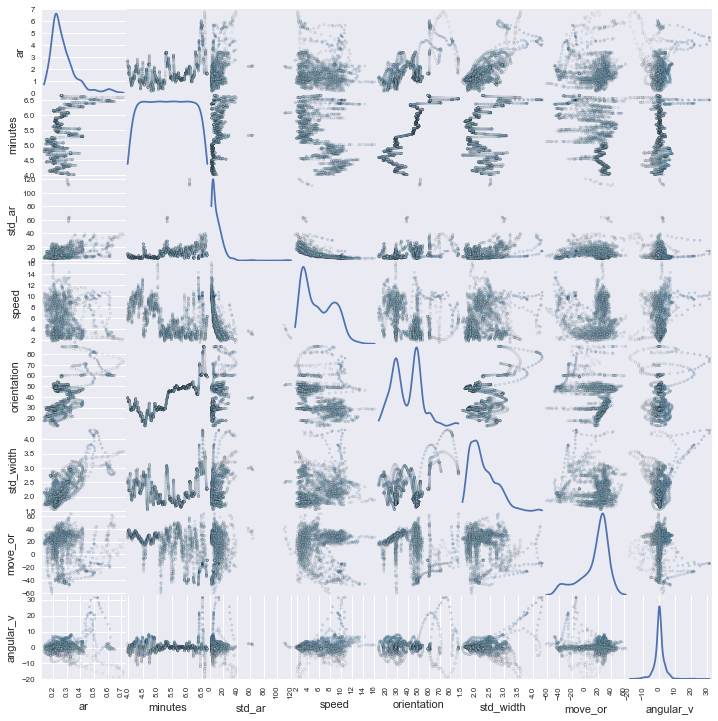

In [47]:
cols= ['ar',
       'minutes',
       #'x', 'y',
        'std_ar',
        'speed',
        'orientation',
        #'std_length',
        'std_width',
        'move_or',
        'angular_v']

df = bc.df.copy()
df = df[(3 <= df['minutes']) & (df['minutes'] >= 4)]
fig = plt.figure(figsize=(12,12))
ax = plt.subplot() #axisbg='white')
#df.plot(kind='scatter', x='std_width', c='ar', y='speed', cmap=mpl.cm.Reds, alpha=0.1, ax=ax)
color_col = 'orientation'
color_col = 'angular_v'

ax = pd.scatter_matrix(df[cols], c=df[color_col], 
                       cmap=mpl.cm.Blues,
                       alpha=0.2, figsize=(12, 12), diagonal='kde', ax=ax)
print(color_col)
plt.show()

2851.8 3600.0
2851.8 3600.0


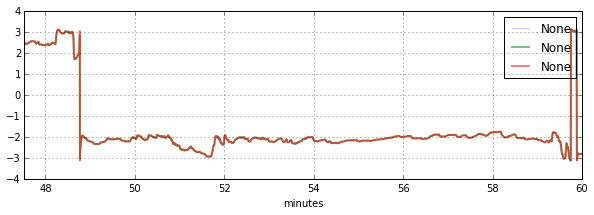

In [660]:
# dt = 0.2
# col = 'speed'
# col = 'speed_along'
# col = 'orientation'


# rdf0 = bc.calculate_columns_df(df=rdf.copy())

# rdf1 = bc.smooth_df(df=rdf.copy())
# rdf1 = bc.equally_space_df(rdf1, dt=dt)
# rdf1 = bc.calculate_columns_df(df=rdf1)

# rdf2 = bc.calculate_columns_df(df=rdf.copy())
# rdf2 = bc.smooth_df(df=rdf2)
# rdf2 = bc.equally_space_df(rdf2, dt=dt)

# rdf3 = bc.smooth_df(df=rdf.copy())
# rdf3 = bc.calculate_columns_df(df=rdf3)
# rdf3 = bc.smooth_df(df=rdf3)
# #rdf3 = bc.equally_space_df(rdf3, dt=dt)

# fig, ax = plt.subplots(figsize=(10,3))
# rdf0.plot(x='minutes', y=col, ax=ax, alpha=0.2)
# rdf2.plot(x='minutes', y=col, ax=ax, color='green', lw=2, alpha=0.5) # not as perfered
# #rdf1.plot(x='minutes', y=col, ax=ax, color='black', lw=2, alpha=0.5) # current method. downsample early
# rdf3.plot(x='minutes', y=col, ax=ax, color='red', lw=2, alpha=0.5)   # my new favorite

# ax.legend()
# #ax.set_xlim([2, 2.5])
# #ax.set_xlim([1, 5])

# #ax.set_ylim([10, 15])

ar


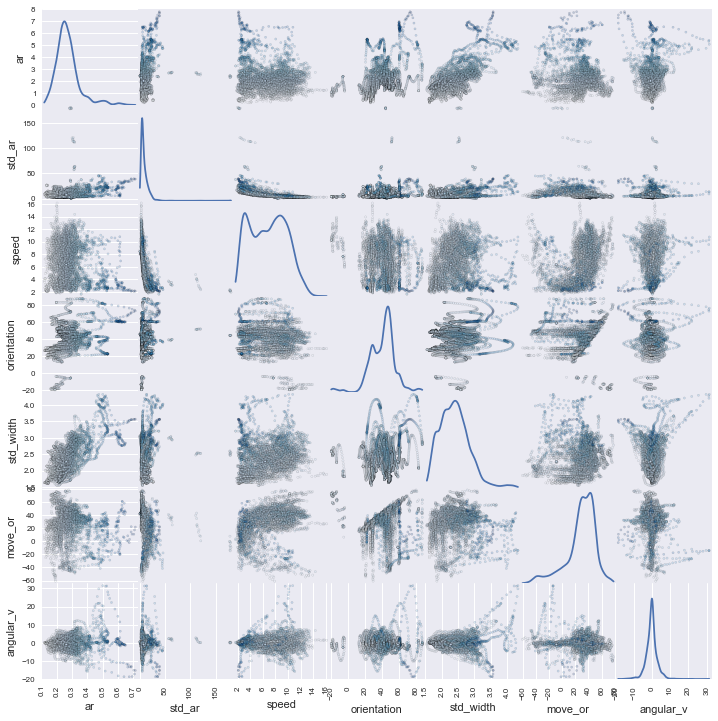

In [38]:
cols= ['ar',
'std_ar',
'speed',
'orientation',
#'std_length',
'std_width',
'move_or',
'angular_v']

df = bc.df.copy()
fig = plt.figure(figsize=(12,12))
ax = plt.subplot() #axisbg='white')
#df.plot(kind='scatter', x='std_width', c='ar', y='speed', cmap=mpl.cm.Reds, alpha=0.1, ax=ax)
color_col = 'ar'
ax = pd.scatter_matrix(df[cols], c=df[color_col], 
                       cmap=mpl.cm.Blues,
                       alpha=0.2, figsize=(12, 12), diagonal='kde', ax=ax)
print(color_col)
plt.show()

In [ ]:
df = bc.df
df_raw = bc.calculate_columns_df(df=bc.raw_df)
#for df in df_list:
#plt.plot(df['minutes'], df['speed'])
#df['hey'] = pd.rolling_mean(df['move_dir'],10, center=True) - df['orientation']
#col = 'speed'
col = 'move_or'
#col = 'orientation'
#col = 'angular_v'
col = 'ar'
col = 'std_ar'
col = 'std_width'
col = 'std_length'

#col = 'x'
#col = 'length'
#col = 'width'
#col = 'vx'
fig, ax = plt.subplots(figsize=(15, 3))
df_raw.plot( x='time', y=col,  alpha=0.3, ax=ax)
df.plot(x='time', y=col, color='red', alpha=0.2, ax=ax)
#df_raw.plot(kind='scatter', x='time', y=col,  alpha=0.7, ax=ax, label='raw')
df.plot(kind='scatter',x='time', y=col, color='red', alpha=0.5, ax=ax, label='smooth')

#pd.rolling_mean(df_raw, 10, center=True).plot( x='time', y=col,  alpha=0.3, ax=ax)
#pd.rolling_mean(df_raw, 10, center=True).plot(x='time', y=col, color='orange', alpha=0.2, ax=ax, label='smooth2')

#ax.plot(df['minutes'], df['hey'])
#ax.set_xlim([200, 250])
ax.set_ylim([-5, 5])
#ax.set_ylim([0, 30])
#ax.set_ylim([1, 5])

ax.set_xlim([200, 250])
#ax.set_xlim([392, 400])
#ax.set_xlim([295, 305])
#ax.set_ylim([720, 765])
plt.show()

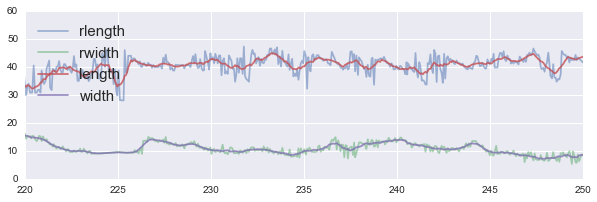

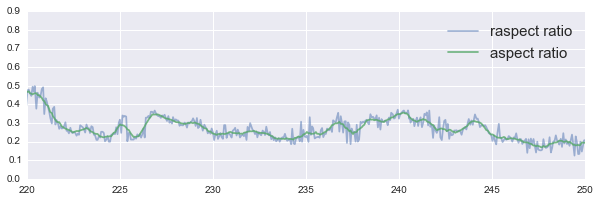

In [832]:
d = df_raw

fig, ax = plt.subplots(figsize=(10, 3))
#ax.plot(df_raw['time'], df_raw[col], '-', alpha=0.7)
ax.plot(d['time'], d['length'], '-', alpha=0.5, label='rlength')
ax.plot(d['time'], d['width'], '-', alpha=0.5, label='rwidth')
ax.plot(df['time'], df['length'], '-', alpha=0.8, label='length')
ax.plot(df['time'], df['width'], '-', alpha=0.8, label='width')
#ax.plot(df['time'], df['width'], '-', alpha=0.5)
ax.legend(loc='best', fontsize=15)
ax.set_xlim([220, 250])
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
#ax.plot(df_raw['time'], df_raw[col], '-', alpha=0.7)
ax.plot(d['time'], d['ar'], '-', alpha=0.5, label='raspect ratio')
ax.plot(df['time'], df['ar'], '-', alpha=0.8, label='aspect ratio')
ax.legend(loc='best', fontsize=15)
#ax.plot(df['time'], df['width'], '-', alpha=0.5)
#ax.plot(df['time'], df['width'], '-', alpha=0.5)
ax.set_xlim([220, 250])
plt.show()

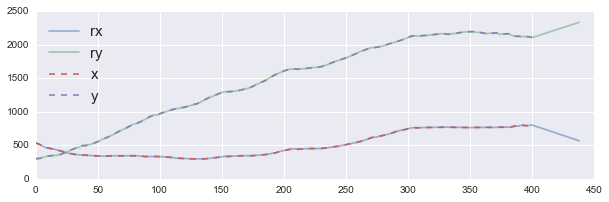

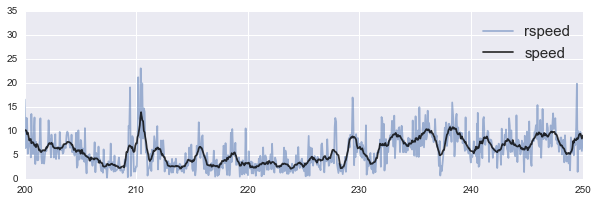

In [834]:
fig, ax = plt.subplots(figsize=(10, 3))
#ax.plot(df_raw['time'], df_raw[col], '-', alpha=0.7)
ax.plot(d['time'], d['x'], '-', alpha=0.5, label='rx')
ax.plot(d['time'], d['y'], '-', alpha=0.5, label='ry')
ax.plot(df['time'], df['x'], '--', alpha=0.8, label='x')
ax.plot(df['time'], df['y'], '--', alpha=0.8, label='y')
#ax.plot(df['time'], df['width'], '-', alpha=0.5)
ax.legend(loc='best', fontsize=15)
#ax.set_xlim([200, 250])

plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
#ax.plot(df_raw['time'], df_raw[col], '-', alpha=0.7)
ax.plot(d['time'], d['speed'], '-', alpha=0.5, label='rspeed')
ax.plot(df['time'], df['speed'], 'k-', alpha=0.8, label='speed')
ax.legend(loc='best', fontsize=15)
#ax.plot(df['time'], df['width'], '-', alpha=0.5)
#ax.plot(df['time'], df['width'], '-', alpha=0.5)
ax.set_xlim([200, 250])
plt.show()

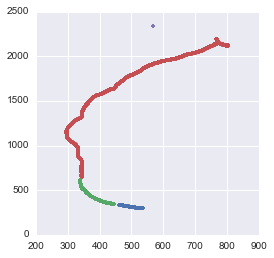

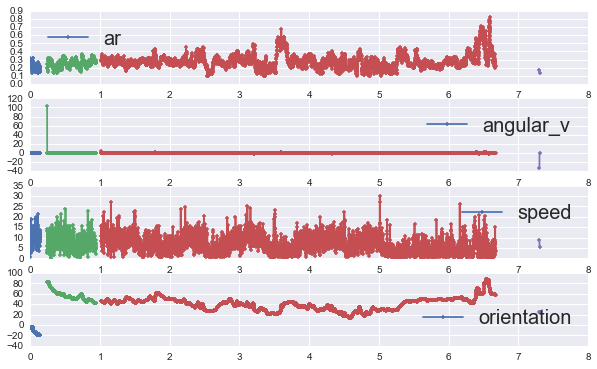

In [33]:
fig, ax = plt.subplots(figsize=(4, 4))
for df in df_list:
    ax.plot(df['x'], df['y'], '.-')
plt.show()

fig, ax = plt.subplots(4, 1, figsize=(10, 6))
for j, df in enumerate(df_list):
    plots = ['ar', 'angular_v', 'speed', 'orientation']
    for i, label in enumerate(plots):
        ax[i].plot(df['minutes'], df[label], '.-', label=label)
        if j == 0:
            ax[i].legend(fontsize=20, loc='best')
plt.show()

In [261]:
# def add_empty_rows(df, keys=None):
#     cols = df.columns
#     index = keys
#     new_rows = np.empty((len(keys), len(cols)))
#     new_rows.fill(np.NAN)
#     df2 = pd.DataFrame(new_rows, index=index, columns=cols)
#     return pd.concat([df, df2]).sort()

# max_gap_frames = 2

# df_list = bc.split_df(max_gap_seconds=5)
# df = df_list[1]

# #for df in df_list:

# ### Fill small gaps using frames
# df = df.set_index(['frame'])
# f0, f1 = df.index[0], df.index[-1]
# df = df.reindex(range(f0, f1))
# df = df.interpolate('linear')
# df = df.reset_index()

# ### Smooth Dataframe
# cols_to_smooth = ['x', 'y', 'length', 'width', 'vx', 'vy']
# df[cols_to_smooth] = pd.rolling_mean(df[cols_to_smooth], window=11)
# df = df.fillna(method='bfill')
# df = df.fillna(method='ffill')

# ### Add rows to fit exact second times.
# df = df.set_index(['time'])
# t0, t1 = np.ceil(df.index[0]), np.floor(df.index[-1])
# print(t0, t1)
# t = np.arange(t0, t1, dtype=int) 
# df = add_empty_rows(df, keys=t)
# df.index.name = 'time'

# ### Interpolate values for exact second times
# df[cols_to_smooth] = df[cols_to_smooth].interpolate('linear')
# df['frame'] = df['frame'].interpolate('nearest')

# ### Downsample to exact second times
# df = df.loc[t]
# df = df.reset_index()

# #df.head(10)

15.0 400.0
